# Linking gene mutations to imaging phenotype deviations in autism

- This example shows how to translate mouse mutation patterns to human and compare with imaging phenotype deviations in autism.
- See the this [**page**](./case4_intro.rst) for more introduction of this tutorial.

In [1]:
import pandas as pd
import numpy  as np
from nilearn import image,plotting
from scipy import stats
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
import pickle
import os

In [2]:
import transbrain as tb

### load deviation pattern

In [3]:
human_deviation_pattern = pd.read_csv('z_autism_regress.csv') # Deviant patterns in autistic individuals

In [4]:
human_deviation_pattern.set_index('Unnamed: 0',inplace=True,drop=True)

In [5]:
mouse_mutation_pattern = pd.read_csv('mouse_mutation_pattern.csv') # Deviant patterns in autism mouse models

In [6]:
mouse_mutation_pattern.set_index('Unnamed: 0',inplace=True,drop=True)

### translating mouse mutation patterns to human

In [7]:
Transformer = tb.trans.SpeciesTrans('bn')

INFO:root:Initialized for bn atlas.


In [8]:
help(Transformer.mouse_to_human)

Help on method mouse_to_human in module transbrain.trans:

mouse_to_human(phenotype: pandas.core.frame.DataFrame, region_type: Literal['cortex', 'subcortex', 'all'] = 'cortex', normalize: bool = True, restore: bool = False) -> pandas.core.frame.DataFrame method of transbrain.trans.SpeciesTrans instance
    Translate mouse phenotype to human.
    
    Parameters
    ----------
    phenotype : pd.DataFrame
        Mouse phenotype DataFrame (regions × phenotypes).
    region_type : {'cortex', 'subcortex', 'all'}, optional
        The brain region type to translate. Default is 'cortex'.
    normalize : bool, optional
        Whether to normalize data before translation. Default is True.
    restore : bool, optional
        Whether to restore values back to original scale after translation. Only used if normalize is True.
        Please enable this parameter with caution, unless you are certain that the distributions of this phenotype are consistent between the two species.
    
    Returns

In [9]:
mutation_trans_in_human = Transformer.mouse_to_human(mouse_mutation_pattern,region_type='all')

INFO:root:Successfully translated mouse all phenotypes to human.


### individual gene risk scores based on mouse model

In [10]:
cross_species_autism_dataframe = pd.DataFrame()

for i in range(human_deviation_pattern.shape[0]):
    
    row_data = human_deviation_pattern.iloc[i].values
    corr_l = []
    
    for j in range(5):

        m_data = mutation_trans_in_human.iloc[:,j].values
        corr_ = stats.pearsonr(row_data,m_data)[0]
        corr_l.append(corr_)

    cross_species_autism_dataframe[i] = corr_l

cross_species_autism_dataframe = cross_species_autism_dataframe.T
cross_species_autism_dataframe.index = human_deviation_pattern.index
cross_species_autism_dataframe.columns = mutation_trans_in_human.columns.values

### load AHBA gene expression

In [12]:
AHBA_ex = pd.read_csv('ahba_expression.csv') # AHBA expression in region level

In [13]:
AHBA_ex.set_index('gene_symbol',inplace=True,drop=True)

### individual gene risk scores based on AHBA

In [14]:
AHBA_autism_dataframe = pd.DataFrame()

for i in range(human_deviation_pattern.shape[0]):
    
    row_data = human_deviation_pattern.iloc[i].values
    corr_l = []
    
    for j in range(5):

        m_data = AHBA_ex.iloc[j].values
        corr_ = stats.pearsonr(row_data,m_data)[0]
        corr_l.append(corr_)

    AHBA_autism_dataframe[i] = corr_l

AHBA_autism_dataframe = AHBA_autism_dataframe.T
AHBA_autism_dataframe.index = human_deviation_pattern.index
AHBA_autism_dataframe.columns = mutation_trans_in_human.columns.values

### correlate risk scores

In [15]:
stats.pearsonr(AHBA_autism_dataframe.values.flatten(),cross_species_autism_dataframe.values.flatten())

PearsonRResult(statistic=0.19780599996495293, pvalue=9.645342333400538e-12)

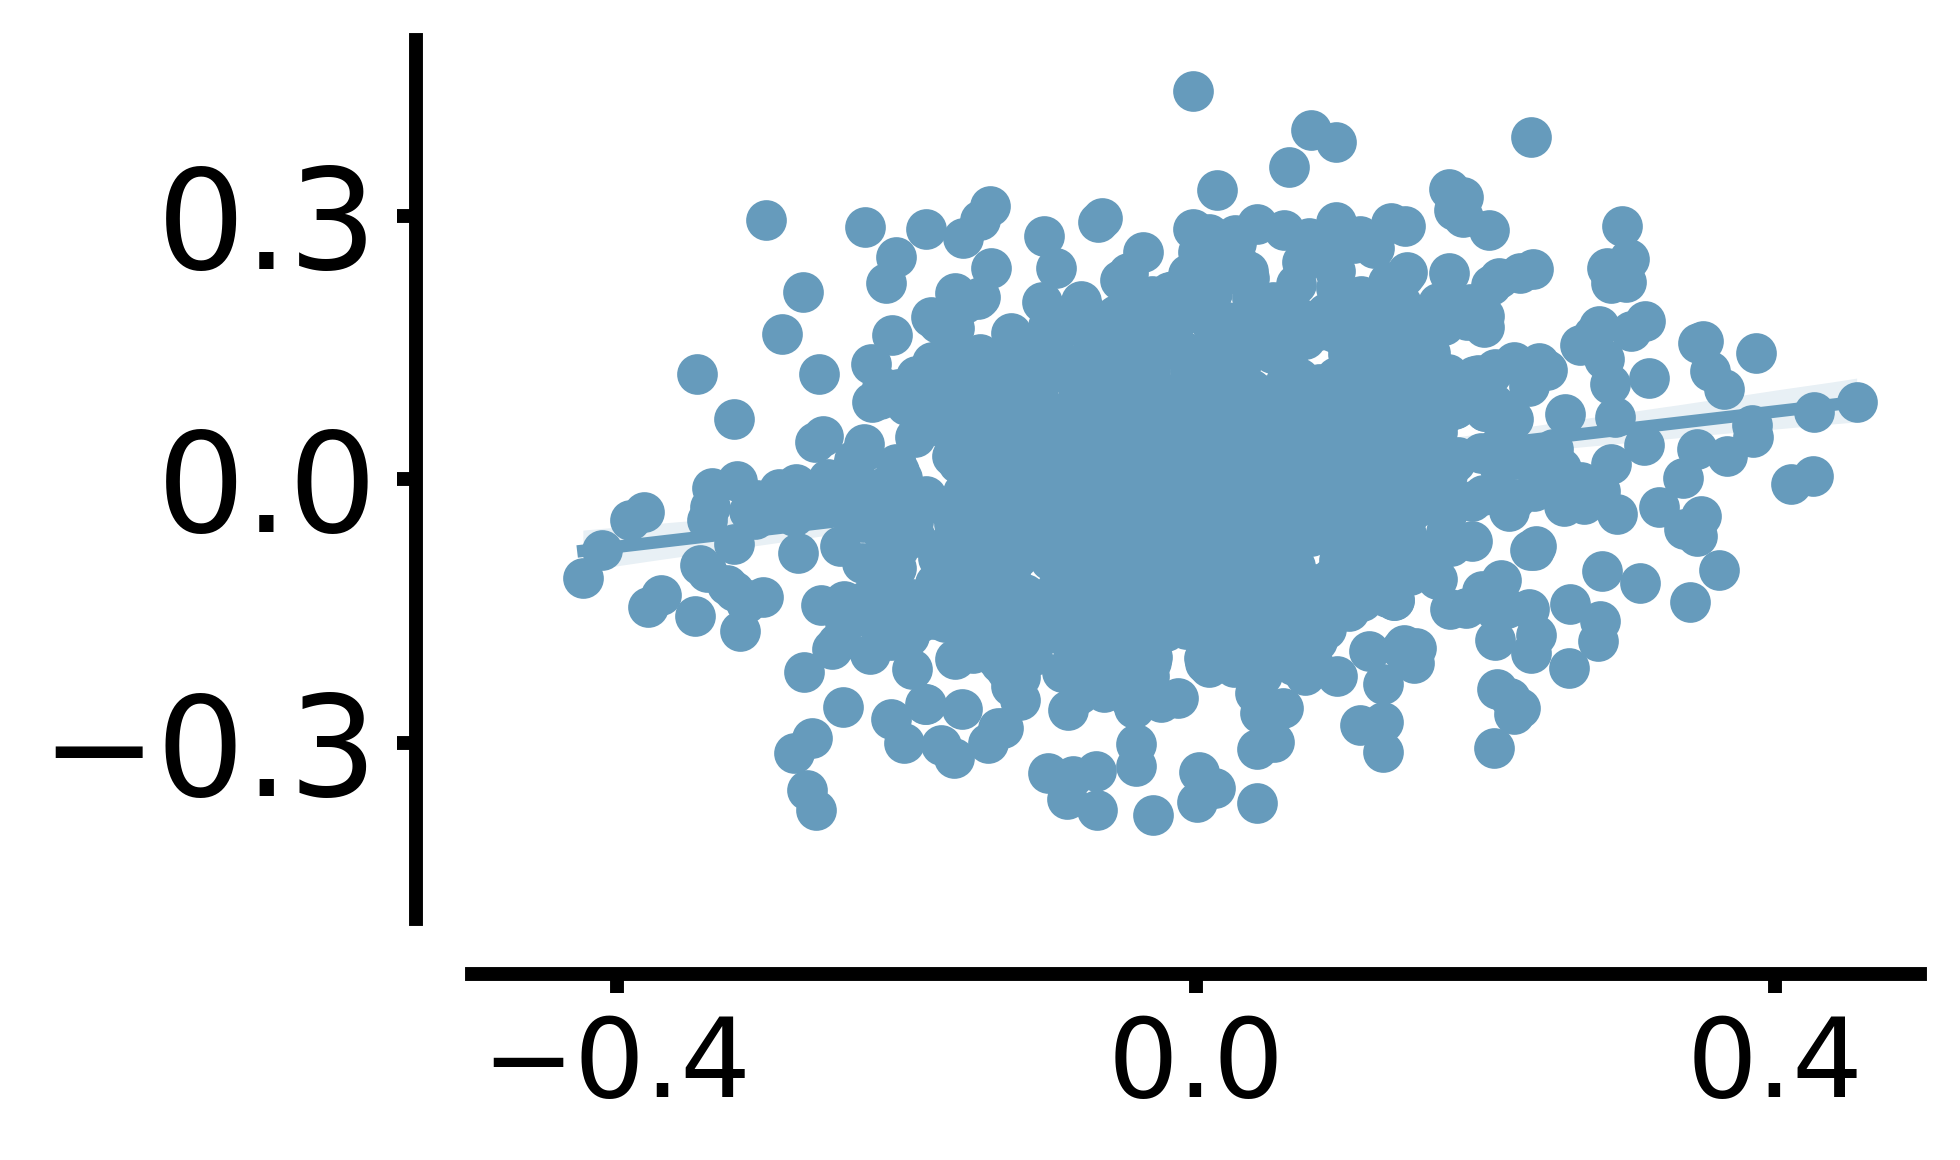

In [16]:
fig,ax=plt.subplots(1,1,figsize=(5,3),dpi=400)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.tick_params(labelsize=15)

for spine in ax.spines.values():
    spine.set_position(('outward', 10))
    
ax.set_ylim(-0.5,0.5)
ax.set_yticks([-0.3,0.0,0.3])

ax.set_xlim(-0.5, 0.5)
ax.set_xticks([-0.4,0.0,0.4])

ax.spines['left'].set_linewidth(2.5) 
ax.spines['bottom'].set_linewidth(2.5) 
ax.tick_params(axis='x', labelsize=20, width=2.5)
ax.tick_params(axis='y', labelsize=25, width=2.5)

sns.regplot(x=AHBA_autism_dataframe.values.flatten(),y=cross_species_autism_dataframe.values.flatten(),color='#669bbc', scatter_kws={'color': '#669bbc', 'edgecolor': '#669bbc', 'linewidths': 1,'alpha':1,'s':40})
plt.tight_layout()

### correlate risk scores in specific gene

In [17]:
dict_gene_ = {}
for gene in ['Dvl1','Magel2','Slc6a4','Sgsh','Shank3--']:
    
    AHBA_scores = AHBA_autism_dataframe[gene].values
    mouse_mutation_scores = cross_species_autism_dataframe[gene].values
    r,p = stats.pearsonr(AHBA_scores,mouse_mutation_scores)
    
    dict_gene_[gene] = (r,p)

In [18]:
dict_gene_

{'Dvl1': (0.31097966299833013, 1.2856342421455238e-06),
 'Magel2': (0.4539929971213872, 3.0064151593370794e-13),
 'Slc6a4': (0.015197117448081244, 0.8175170464931003),
 'Sgsh': (0.002248242177818731, 0.9727707705317751),
 'Shank3--': (0.20016237908524429, 0.0021402800433741828)}

### correlating sythetic mutation pattern with AHBA gene expression

In [19]:
dict_gene_ = {}
for gene1,gene2 in zip(['DVL1','MAGEL2','SLC6A4','SGSH','SHANK3'],['Dvl1','Magel2','Slc6a4','Sgsh','Shank3--']):
    r,p = stats.pearsonr(AHBA_ex.T[gene1].values,mutation_trans_in_human[gene2].values)
    dict_gene_[gene1] = (r,p)

In [20]:
dict_gene_

{'DVL1': (0.09730098359735115, 0.2764762751949792),
 'MAGEL2': (0.3526186809312027, 4.78449085894465e-05),
 'SLC6A4': (-0.062062969713091054, 0.4882044955368892),
 'SGSH': (0.04501704457506566, 0.6152770360499245),
 'SHANK3': (-0.06759348765582845, 0.4502055153591825)}

In [21]:
dict_gene_ = {}
for gene1,gene2 in zip(['DVL1','MAGEL2','SLC6A4','SGSH','SHANK3'],['Dvl1','Magel2','Slc6a4','Sgsh','Shank3--']):
    r,p = stats.pearsonr(AHBA_ex.T[gene1].values[:105],mutation_trans_in_human[gene2].values[:105])
    dict_gene_[gene1] = (r,p)

In [22]:
dict_gene_

{'DVL1': (0.09163004800347647, 0.35255399643853036),
 'MAGEL2': (0.5926688876223712, 2.729502948534346e-11),
 'SLC6A4': (-0.008573793435634278, 0.9308263894863134),
 'SGSH': (0.1400033418271194, 0.15431322372547143),
 'SHANK3': (0.09513931972764542, 0.33433944229094237)}

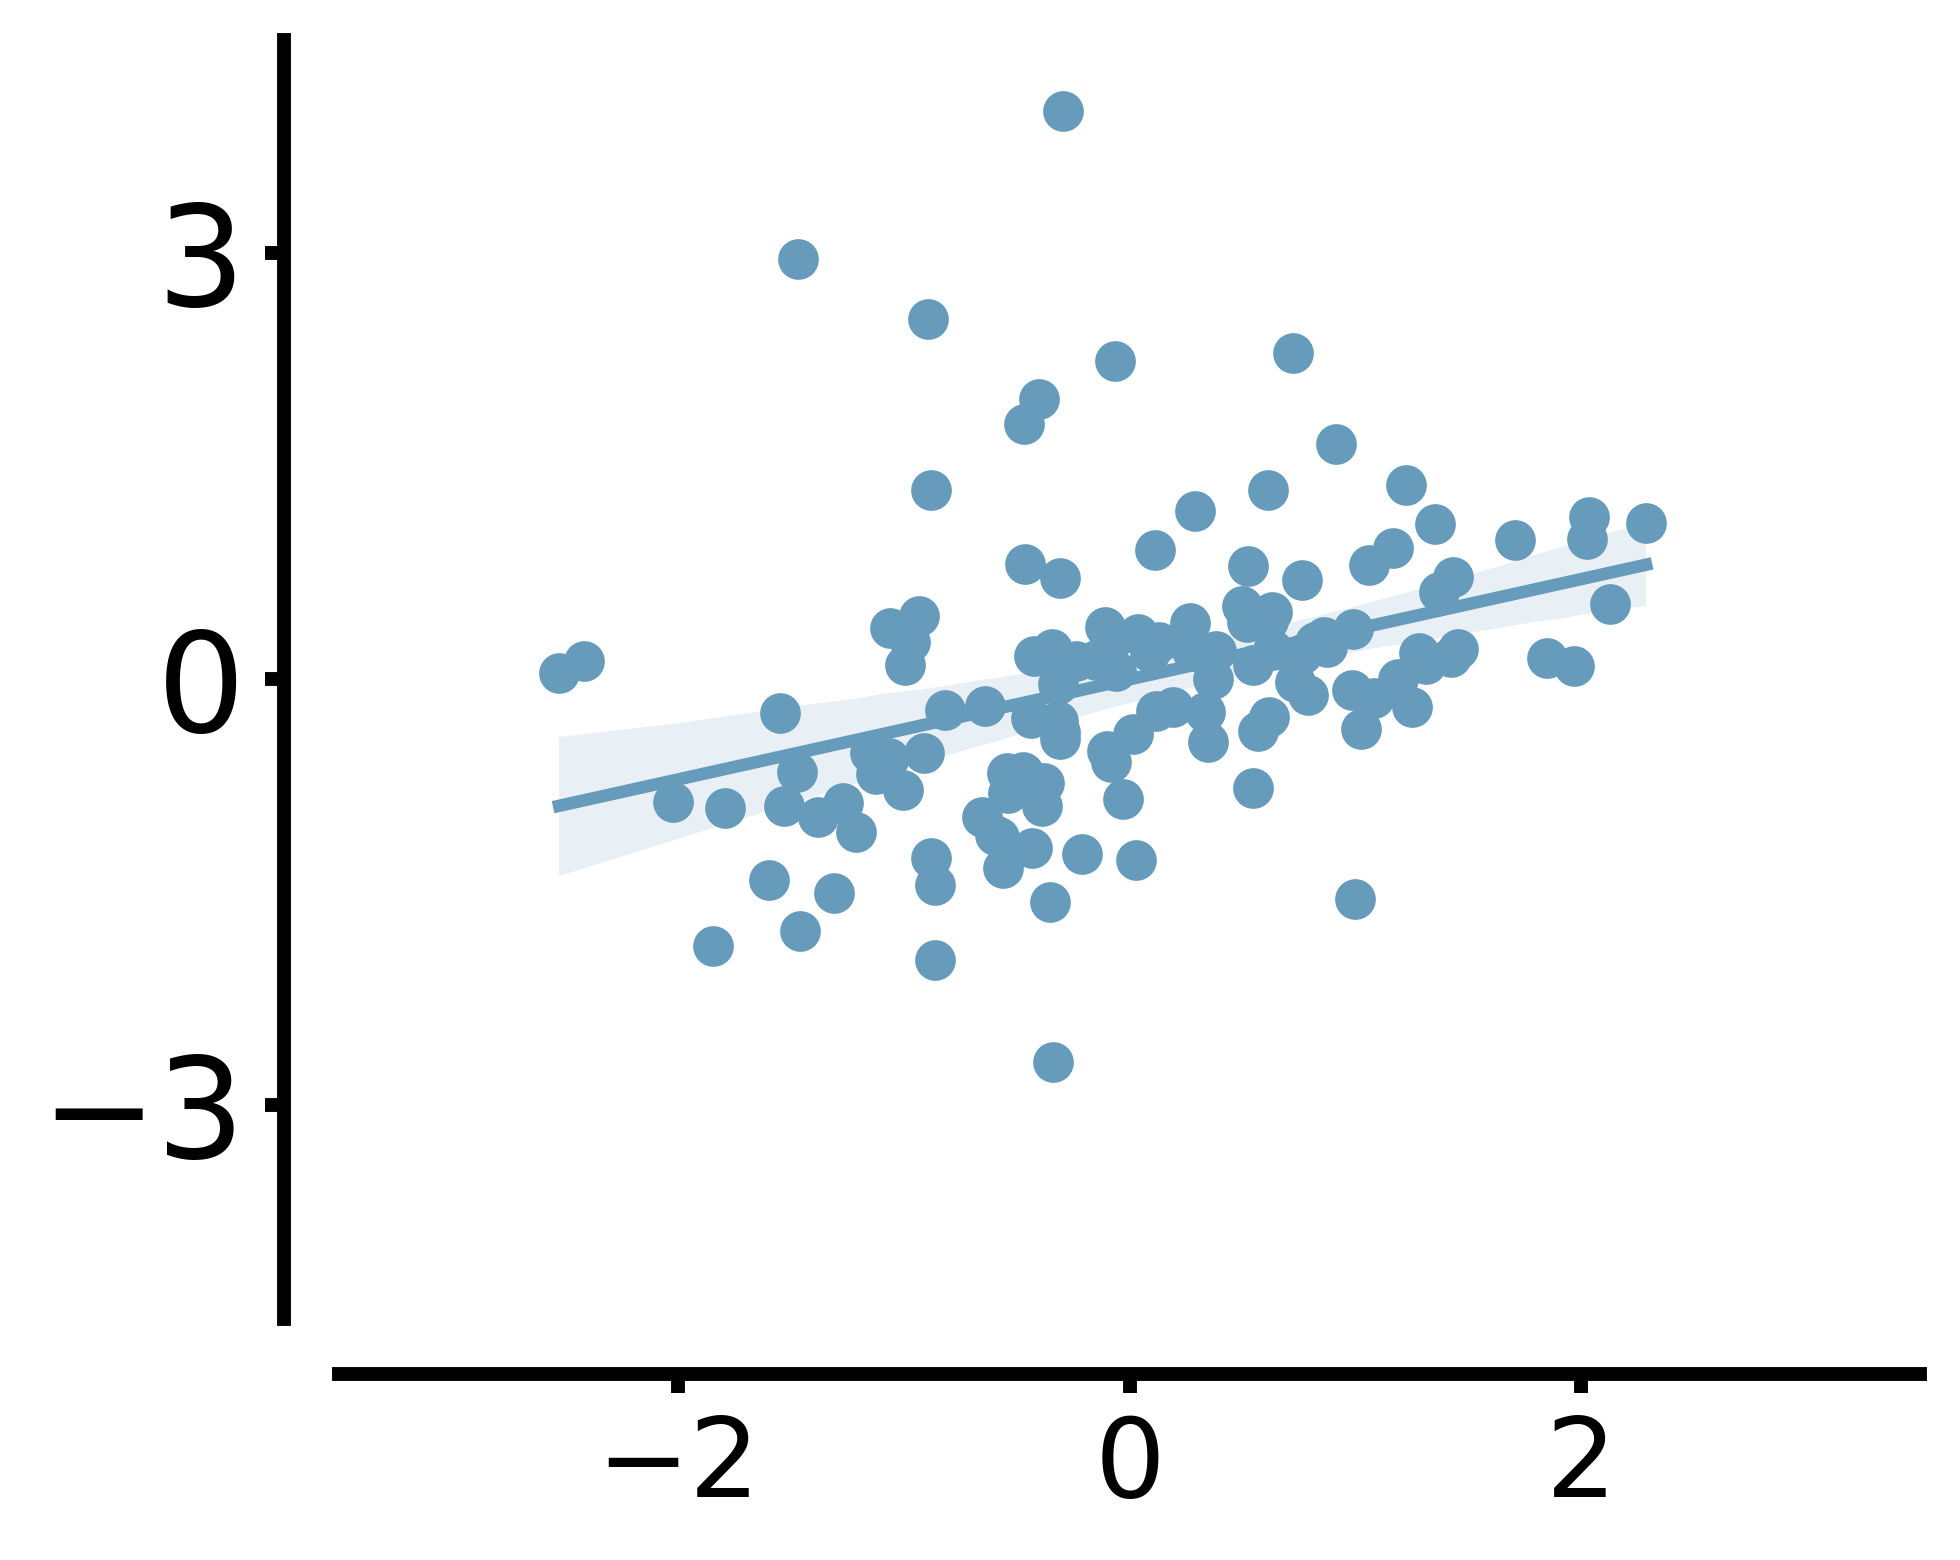

In [23]:
fig,ax=plt.subplots(1,1,figsize=(5,4),dpi=400)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.tick_params(labelsize=15)

for spine in ax.spines.values():
    spine.set_position(('outward', 10))
    
ax.set_ylim(-4.5,4.5)
ax.set_yticks([-3,0,3])

ax.set_xlim(-3.5, 3.5)
ax.set_xticks([-2,0,2])

ax.spines['left'].set_linewidth(2.5) 
ax.spines['bottom'].set_linewidth(2.5) 
ax.tick_params(axis='x', labelsize=20, width=2.5)
ax.tick_params(axis='y', labelsize=25, width=2.5)

sns.regplot(x=stats.zscore(mutation_trans_in_human['Magel2'].values.flatten()),y=stats.zscore(AHBA_ex.T['MAGEL2'].values.flatten()),color='#669bbc', scatter_kws={'color': '#669bbc', 'edgecolor': '#669bbc', 'linewidths': 1,'alpha':1,'s':40})
plt.tight_layout()

### load behavior data

In [25]:
autism_meta = pd.read_csv('meta_info_abide.csv')
autism_meta['SUB_ID'] = ['sub-00{}'.format(i) for i in autism_meta['SUB_ID'].values]
autism_meta.set_index('SUB_ID',inplace=True,drop=True)
autism_info = human_deviation_pattern.index.values
autism_meta = autism_meta.T[autism_info].T

In [26]:
behavior_l = ['FIQ','VIQ','PIQ','ADOS_COMM','ADOS_SOCIAL','ADOS_STEREO_BEHAV']

In [27]:
autism_meta = autism_meta[behavior_l]

In [28]:
autism_meta

,FIQ,VIQ,PIQ,ADOS_COMM,ADOS_SOCIAL,ADOS_STEREO_BEHAV
SUB_ID,,,,,,
sub-0050952,134.0,139.0,120.0,7.0,10.0,4.0
sub-0050953,132.0,139.0,117.0,3.0,10.0,3.0
sub-0050954,78.0,79.0,80.0,3.0,8.0,4.0
sub-0050955,93.0,96.0,91.0,3.0,11.0,3.0
sub-0050956,115.0,115.0,110.0,2.0,8.0,5.0
...,...,...,...,...,...,...
sub-0050528,100.0,90.0,109.0,5.0,7.0,1.0
sub-0050529,128.0,122.0,127.0,4.0,9.0,1.0
sub-0050530,106.0,120.0,91.0,3.0,10.0,0.0


In [29]:
magel2_scores_based_on_mouse = cross_species_autism_dataframe['Magel2'].values

In [30]:
gene_behavior_l = []
gene_clinic_dataframe = pd.DataFrame()

for name_ in autism_meta.columns.values:
    
    behavior_pattern = autism_meta[name_].values
    
    behavior_pattern = np.array([float(x) if str(x).replace('.', '', 1).isdigit() else np.nan for x in behavior_pattern])
    mask = ~np.isnan(behavior_pattern) & (behavior_pattern!=-9999.0)
    
    arr1_filtered = magel2_scores_based_on_mouse[mask]
    arr2_filtered = behavior_pattern[mask]
    
    corr = stats.pearsonr(arr1_filtered,arr2_filtered)
    
    gene_behavior_l.append(corr)
    
gene_clinic_dataframe['magel2'] = gene_behavior_l

In [31]:
gene_clinic_dataframe

,magel2
0,"(-0.17657536932333698, 0.00701340405507845)"
1,"(-0.07795466860082743, 0.2358864146002949)"
2,"(-0.18717492106148584, 0.004224509163950006)"
3,"(-0.08570567055260474, 0.25533156937957996)"
4,"(0.0025750174236128893, 0.9727870157319674)"
5,"(-0.018771597619276183, 0.8046910213502325)"


In [32]:
behavior_pattern = autism_meta['FIQ'].values
behavior_pattern = np.array([float(x) if str(x).replace('.', '', 1).isdigit() else np.nan for x in behavior_pattern])
mask = ~np.isnan(behavior_pattern) & (behavior_pattern!=-9999.0)

In [33]:
arr1_filtered = magel2_scores_based_on_mouse[mask]
arr2_filtered = behavior_pattern[mask]

In [34]:
stats.pearsonr(arr1_filtered,arr2_filtered)

PearsonRResult(statistic=-0.17657536932333698, pvalue=0.00701340405507845)

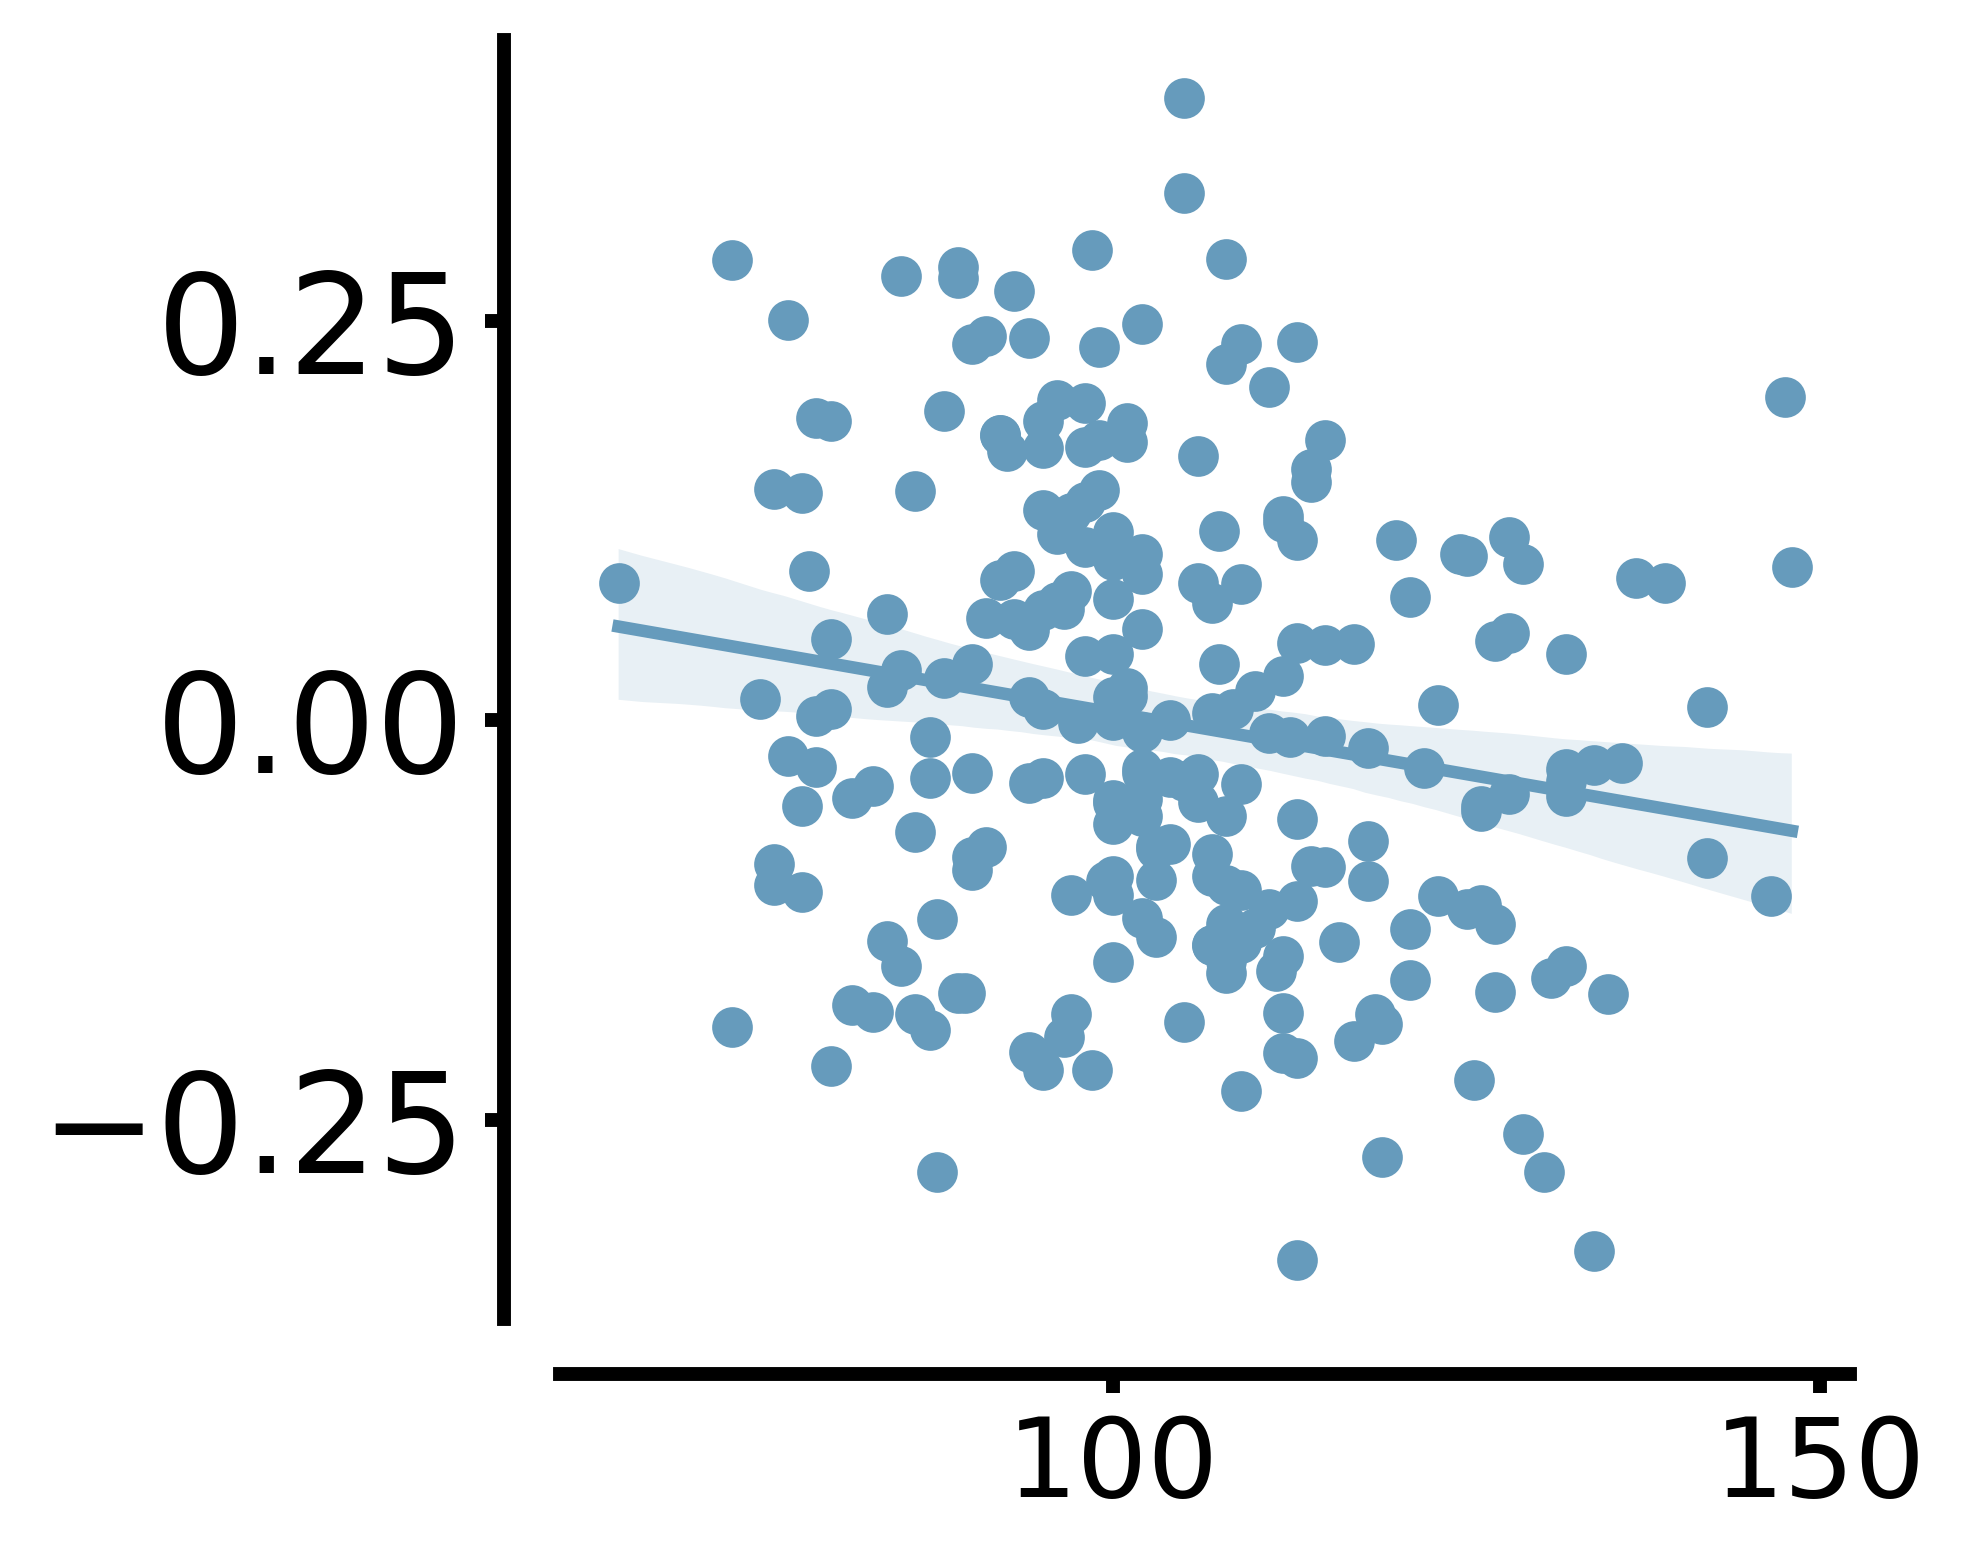

In [35]:
fig,ax=plt.subplots(1,1,figsize=(5,4),dpi=400)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.tick_params(labelsize=15)

for spine in ax.spines.values():
    spine.set_position(('outward', 10))
    
ax.spines['left'].set_linewidth(2.5) 
ax.spines['bottom'].set_linewidth(2.5) 
ax.tick_params(axis='x', labelsize=20, width=2.5)
ax.tick_params(axis='y', labelsize=25, width=2.5)

sns.regplot(x=arr2_filtered,y=arr1_filtered,color='#669bbc', scatter_kws={'color': '#669bbc', 'edgecolor': '#669bbc', 'linewidths': 1,'alpha':1,'s':40})
plt.tight_layout()